# Exploratory Data Analysis

Let's evaluate the data available on this dataset. It has 20,000 chess matches collected from Lichess (games taken of users from the top ~100 teams on _lichess.org_ from 2013 to 2017) available at https://www.kaggle.com/datasnaek/chess.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
%pylab inline

pd.set_option('display.max_columns', 200)

Populating the interactive namespace from numpy and matplotlib


In [2]:
BASE_PATH = "../Bases/"

Importing the dataset:

In [4]:
chess_games = pd.read_csv(BASE_PATH + 'games.csv', delimiter=',')

In [6]:
chess_games.head(2)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4


In [7]:
chess_games.shape

(20058, 16)

## Exploring the data

Let's explore the fields in order to suggest variables to create the model.

In [10]:
chess_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


In [5]:
chess_games.isnull().mean()

id                0.0
rated             0.0
created_at        0.0
last_move_at      0.0
turns             0.0
victory_status    0.0
winner            0.0
increment_code    0.0
white_id          0.0
white_rating      0.0
black_id          0.0
black_rating      0.0
moves             0.0
opening_eco       0.0
opening_name      0.0
opening_ply       0.0
dtype: float64

We don't have any missing values in the columns.

### Rated

In [12]:
chess_games['rated'].value_counts()

True     16155
False     3903
Name: rated, dtype: int64

We have more rated games than not.

### Date of Creation

In [15]:
pd.to_datetime(chess_games['created_at'], unit='ms').describe()

C:\Users\marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                          20058
unique                         13151
top              2017-08-31 20:06:40
freq                              45
first     2013-08-17 20:33:53.173000
last      2017-09-04 02:45:43.790000
Name: created_at, dtype: object

The games were played between 08/2013 and 09/2017.

### Game delay and Time label

In [16]:
games_delay_in_sec = (chess_games['last_move_at'] - chess_games['created_at']) / 1000
games_delay_in_sec.describe()

count     20058.000000
mean        869.707050
std        4814.222091
min           0.000000
25%           0.000000
50%         240.612000
75%         793.171250
max      605844.701000
dtype: float64

The delays are the duration of the matches. From 0 (probably the last_move_at field was not registered) until 605844.7 seconds =~ 7 days, which may probably be an incorrect value or a match of correspondence chess, a possible variety of game at _lichess.org_.

### Turns

In [17]:
chess_games['turns'].describe()

count    20058.000000
mean        60.465999
std         33.570585
min          1.000000
25%         37.000000
50%         55.000000
75%         79.000000
max        349.000000
Name: turns, dtype: float64

It's important to note that 1 turn is a white's move OR a black's move.

### Winner

This will be our target.

In [18]:
chess_games['winner'].value_counts()

white    10001
black     9107
draw       950
Name: winner, dtype: int64

### Victory Status

In [19]:
chess_games['victory_status'].value_counts()

resign       11147
mate          6325
outoftime     1680
draw           906
Name: victory_status, dtype: int64

We see that both 'winner' and 'victory_status' have 'draw' fields, but with different values.

Let's analyse 'victory_status' distribution in the drawn games:

In [20]:
for vic_status in chess_games['victory_status'].unique():
    print(vic_status)
    print(chess_games[(chess_games['victory_status'] == vic_status) & (chess_games['winner'] == 'draw')].shape)
    print()

outoftime
(44, 16)

resign
(0, 16)

mate
(0, 16)

draw
(906, 16)



So there are matches that ended by 'outoftime' with a 'draw' result. This happens at insufficient material positions.

### Increment Code

These are the time controls of the matches.

In [13]:
chess_games['increment_code'].value_counts()

10+0     7721
15+0     1311
15+15     850
5+5       738
5+8       697
         ... 
4+15        1
35+15       1
25+12       1
60+15       1
19+8        1
Name: increment_code, Length: 400, dtype: int64

In [14]:
chess_games['increment_code'].str.match(pat='\d+[+]\d+').value_counts()

True    20058
Name: increment_code, dtype: int64

It seems like every entry in the field time control is of the form minutes+increment_seconds, we confirm that in the following command.

In [15]:
minutes = chess_games['increment_code'].str.split('+').map(lambda time_control: time_control[0], na_action=None)
minutes = minutes.astype(int).value_counts().sort_index()
minutes

0        45
1        31
2        55
3        57
4        65
5      1795
6       176
7       661
8       924
9       261
10     9456
11       98
12      225
13       74
14       70
15     3382
16       49
17       40
18       26
19       28
20      936
21        1
25      322
29        2
30      746
35       26
40       37
45      158
60      103
90       26
120      16
150      13
180     154
Name: increment_code, dtype: int64

The greatest minutes field value is 180 min.

In [16]:
incr_seconds = chess_games['increment_code'].str.split('+').map(lambda time_control: time_control[1], na_action=None)
incr_seconds = incr_seconds.astype(int).value_counts().sort_index()
incr_seconds

0      11098
1        234
2        657
3        456
4        168
5       2068
6        185
7        181
8       1220
9        112
10      1401
11        28
12        87
13        16
14        59
15      1167
16        26
17        30
18        11
19         7
20       125
21         6
25        62
30       297
35         7
40        41
45       107
60       105
90         2
120        4
150        2
180       89
Name: increment_code, dtype: int64

The max increment is 180 seconds per move (1 minute 30 seconds).

### Ratings

For White:

In [17]:
chess_games['white_rating'].describe()

count    20058.000000
mean      1596.631868
std        291.253376
min        784.000000
25%       1398.000000
50%       1567.000000
75%       1793.000000
max       2700.000000
Name: white_rating, dtype: float64

For Black:

In [18]:
chess_games['black_rating'].describe()

count    20058.000000
mean      1588.831987
std        291.036126
min        789.000000
25%       1391.000000
50%       1562.000000
75%       1784.000000
max       2723.000000
Name: black_rating, dtype: float64

Both vary between [291, ~2700].

### Opening ECO

In [19]:
chess_games['opening_eco'].value_counts()

A00    1007
C00     844
D00     739
B01     716
C41     691
       ... 
B60       1
C09       1
E63       1
D22       1
D47       1
Name: opening_eco, Length: 365, dtype: int64

## Features

### Duration of the match

In [20]:
chess_games['duration_in_seconds'] = games_delay_in_sec.copy()

### One-Hot-Encoding of victory status

In [21]:
from category_encoders import OneHotEncoder

In [22]:
ohe_victory_status = OneHotEncoder(cols=['victory_status'], use_cat_names=True, drop_invariant=True)
chess_games = ohe_victory_status.fit_transform(chess_games)

### Time control: Minutes and Seconds

In [23]:
minutes = chess_games['increment_code'].str.split('+').map(lambda time_control: time_control[0], na_action=None).astype(int)
incr_seconds = chess_games['increment_code'].str.split('+').map(lambda time_control: time_control[1], na_action=None).astype(int)

chess_games['minutes'] = minutes.copy()
chess_games['incr_seconds'] = incr_seconds.copy()

In [24]:
chess_games = chess_games.drop(columns=['increment_code'], axis=1)

### Date of Creation and Last Move At (as dates)

In [25]:
chess_games['created_at'] = pd.to_datetime(chess_games['created_at'], unit='ms')
chess_games['last_move_at'] = pd.to_datetime(chess_games['last_move_at'], unit='ms')

### Rating difference

One other variable that seems to be predictive is the rating difference between the players.

In [26]:
chess_games['rating_difference'] = chess_games['white_rating'] - chess_games['black_rating']

In [27]:
chess_games['rating_difference'].mean()

7.799880346993718

## Clean Data

Let's clean matches that have a non convenient **number of turns**.

There are matches with until 3 turns, which are not useful for result predictions, since no match can have a certain result in 3 turns. Let's see how many they are.

In [28]:
chess_games[chess_games['turns'] <= 3].shape

(290, 22)

In [29]:
chess_games = chess_games[chess_games['turns'] > 3]

Now, let's plot the distribution of **duration in seconds** for the dataset.

We define a maximum threshold for the delay of the matches (in hours).

It's based on the maximum number of minutes, max of increment seconds by move and the mean quantity of moves in a match of the dataset.

It supposes all the time is consumed in the match.

In [30]:
max_minutes = chess_games['minutes'].max()
max_incr_seconds = chess_games['incr_seconds'].max()
mean_moves = chess_games['turns'].mean()

duration_threshold_in_hours = (max_minutes + max_incr_seconds / 60 * mean_moves) / 60
duration_threshold_in_hours

6.066010724403076

Let's separate the matches that, theoretically, take more than 6 hours to finish.

In [31]:
(chess_games['duration_in_seconds'] < duration_threshold_in_hours * 3600).value_counts()

True     19766
False        2
Name: duration_in_seconds, dtype: int64

In [32]:
chess_games_invalid_duration = chess_games[chess_games['duration_in_seconds'] >= duration_threshold_in_hours * 3600]
chess_games = chess_games[chess_games['duration_in_seconds'] < duration_threshold_in_hours * 3600]

In [33]:
chess_games.shape

(19766, 22)

In [34]:
chess_games_invalid_duration.shape

(2, 22)

Let's evaluate those matches with duration equal to 0.

In [35]:
(chess_games['duration_in_seconds'] == 0).value_counts()

False    11294
True      8472
Name: duration_in_seconds, dtype: int64

What are the results for these matches?

In [36]:
duration0 = chess_games[chess_games['duration_in_seconds'] == 0]
duration0['winner'].value_counts()

white    4207
black    3910
draw      355
Name: winner, dtype: int64

So, there are not only draws (it would be possible to register as draws aborted matches, for example, we see that's not the case).

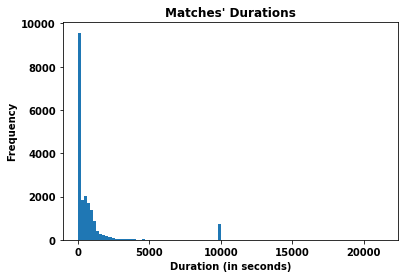

In [37]:
pyplot.hist(x=chess_games['duration_in_seconds'], bins=100)
pyplot.xlabel('Duration (in seconds)')
pyplot.ylabel('Frequency')
pyplot.title('Matches\' Durations')
pyplot.show()

Let's separate the matches that duration_in_seconds == 0.

In [38]:
chess_games_invalid_duration = pd.concat([chess_games_invalid_duration, duration0], ignore_index=False)
chess_games = chess_games[chess_games['duration_in_seconds'] > 0]

In [39]:
chess_games.shape

(11294, 22)

In [40]:
chess_games_invalid_duration.shape

(8474, 22)

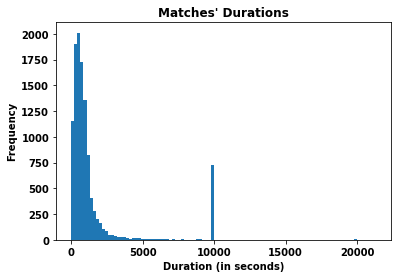

In [41]:
pyplot.hist(x=chess_games['duration_in_seconds'], bins=100)
pyplot.xlabel('Duration (in seconds)')
pyplot.ylabel('Frequency')
pyplot.title('Matches\' Durations')
pyplot.show()

For our first analysis, we'll consider the dataset 'chess_games' and 'chess_games_invalid_duration' (this one without the 'duration_in_seconds' fields).

The peak at ~10000 s = ~2.7 hours, which is a plausible match duration.